In [1]:
from netCDF4 import Dataset
import numpy as np
from pymbar import bar
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

### Quick function to calculate the free energies between proposals using BAR

In [2]:
def calc_free_energy_from_logp(initial, final, proposals, lopP, bias, nwats):
    """
    Calculate free energies from acceptance probabilty and SAMS bias
    """
    work_add = []
    work_remove = []
    
    for i in range(len(proposals)):
        if np.all(proposals[i] == np.array([initial, final])):
            cost = bias[i][final] - bias[i][initial]
            work_add.append(-lopP[i] - cost)
        elif np.all(proposals[i] == np.array([final, initial])):
            cost = bias[i][final] - bias[i][initial]
            work_remove.append(-lopP[i] + cost)

    work_add = np.array(work_add)
    work_remove = np.array(work_remove)    
    return bar.BAR(work_add, work_remove, compute_uncertainty=True)

def calc_volume(volume, nsalt):
    """
    Estimate the volume of the system as a function of number of salt pairs present.
    """
    average = np.zeros(np.max(nsalt) + 1)
    error = np.zeros(np.max(nsalt) + 1)
    
    for n in range(np.max(nsalt) + 1):
        voln = volume[np.where(nsalt==n)] 
        average[n] = voln.mean()
        error[n] = voln.std() / np.sqrt(len(voln))
    
    return average, error
        
def predict_average_number(deltachem, f, saltmax=20):
    """
    Calculate the average amount of salt at a given chemical potential and free energies
    """
    nsalt = np.arange(0, saltmax + 1)
    exponents = deltachem * nsalt + f
    a = np.max(exponents)
    numerator = np.sum(nsalt * np.exp(exponents - a))
    denominator = np.sum(np.exp(exponents - a))
    return numerator/denominator

def predict_concentration(deltachem, f, mean_volume, saltmax=20):
    """
    Calculate the average amount of salt at a given chemical potential and free energies
    """
    nsalt = np.arange(0, saltmax + 1)
    exponents = deltachem * nsalt + f
    a = np.max(exponents)
    numerator = np.sum(nsalt * np.exp(exponents - a))
    denominator = np.sum(mean_volume*np.exp(exponents - a))
    return numerator/denominator

### Reading in the SAMS data

In [3]:
files = ['out1.nc', 'out2.nc', 'out3.nc']

volume = []
logP = []
sams_bias = []
nwats = []
nsalt = []
proposal = []

for file in files:
    ncfile = Dataset(file,'r')
    volume.append(ncfile.groups['Sample state data']['volume'][:])
    logP.append(ncfile.groups['Sample state data']['log_accept'][:])
    sams_bias.append(ncfile.groups['Sample state data']['sams bias'][:])
    proposal.append(ncfile.groups['Sample state data']['proposal'][:][:,0,:])
    nspecies = ncfile.groups['Sample state data']['species counts']
    nwats.append(nspecies[:,0])
    nsalt.append(nspecies[:,1])
    ncfile.close()

volume = np.array(volume)
volume = volume.reshape(volume.shape[0]*volume.shape[1])
nwats = np.array(nwats)
nwats = nwats.reshape(nwats.shape[0]*nwats.shape[1])
nsalt = np.array(nsalt)
nsalt = nsalt.reshape(nsalt.shape[0]*nsalt.shape[1])
logP = np.array(logP)
logP = logP.reshape(logP.shape[0]*logP.shape[1])
proposal = np.array(proposal)
proposal = proposal.reshape(proposal.shape[0]*proposal.shape[1],2)
sams_bias = np.array(sams_bias)
sams_bias = sams_bias.reshape(sams_bias.shape[0]*sams_bias.shape[1],sams_bias.shape[2])

### Calculating the Gibbs free energy to exchange salt for water

In [4]:
saltmax = 20
error = np.zeros(saltmax)
free = np.zeros(saltmax)
for i in range(saltmax):
    f, e = calc_free_energy_from_logp(i, i + 1, proposal, logP, sams_bias, nwats)
    free[i] = f
    error[i] = e

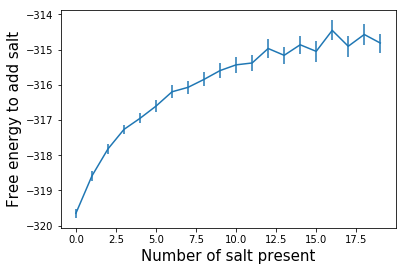

In [5]:
plt.errorbar(range(saltmax),free, yerr=error*2)
plt.xlabel('Number of salt present', fontsize=15)
plt.ylabel('Free energy to add salt', fontsize=15)
plt.show()

### Viewing how the average volume of the system varies with salt present

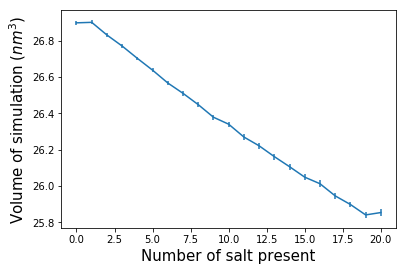

In [6]:
ave_vol, err_vol = calc_volume(volume, nsalt)
x = np.arange(np.max(nsalt)+1)
plt.errorbar(x, ave_vol, yerr=err_vol*2)
plt.xlabel('Number of salt present', fontsize=15)
plt.ylabel('Volume of simulation ($nm^3$)', fontsize=15)
plt.show()

## Predicting the concetration based on free energies and volume
### Box edge = 30 Angstroms 

In [7]:
path = '/Users/rossg/Work/saltswap-results/calibration/equilibrium_staging/box_edge30/'
results_folders = glob(path + 'deltamu_3*')

burnin = 100

b30_mean_salt = []
b30_error_salt = []
b30_deltachem = []
b30_mean_volume = []
b30_error_volume = []
b30_mean_conc = []
b30_error_conc = []


for folder in results_folders:
    ncfile = Dataset(folder + '/out.nc')
    b30_deltachem.append(ncfile.groups['Control parameters']['delta_chem'][0])
    nsalt = ncfile.groups['Sample state data']['species counts'][0::4][:,1]
    b30_mean_salt.append(np.mean(nsalt[burnin:]))
    b30_error_salt.append(np.std(nsalt[burnin:]) / np.sqrt(len(nsalt)))
    volume = ncfile.groups['Sample state data']['volume'][:]
    b30_mean_volume.append(np.mean(volume))
    b30_error_volume.append(np.std(volume) / np.sqrt(len(volume)))
    b30_mean_conc.append(np.mean(nsalt / volume))
    b30_error_conc.append(np.std(nsalt / volume) / np.sqrt(len(volume)))
    
b30_mean_salt = np.array(b30_mean_salt)
b30_error_salt = np.array(b30_error_salt)
b30_deltachem = np.array(b30_deltachem)
b30_mean_volume = np.array(b30_mean_volume)
b30_error_volume = np.array(b30_error_volume)

b30_mean_conc = np.array(b30_mean_conc)
b30_error_conc = np.array(b30_error_conc)

#### Predicting the concentration for the above

In [8]:
d = np.linspace(b30_deltachem[0],b30_deltachem[-1])
free_energy = np.hstack((0.0,np.cumsum(free)))

predicted_conc = np.zeros(len(d))
for i in range(len(d)):
    predicted_conc[i] = predict_concentration(-d[i], saltmax=20, mean_volume=ave_vol, f=-free_energy)

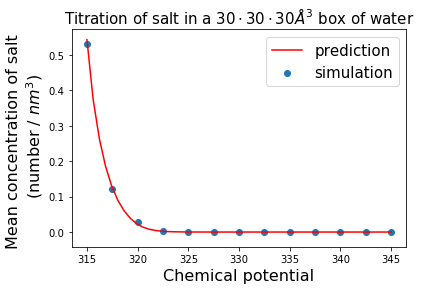

In [9]:
plt.scatter(b30_deltachem, b30_mean_conc, marker='o', label='simulation')
plt.plot(d, predicted_conc, color='red', label='prediction')
plt.xlabel('Chemical potential', fontsize=16)
plt.ylabel('Mean concentration of salt \n (number / $nm^3$)', fontsize=16)
plt.title('Titration of salt in a $30\cdot 30\cdot 30 \AA^3 $ box of water', fontsize=15)
plt.legend(fontsize=15)
plt.show()

### Box edge = 40 Angstroms

In [10]:
path = '/Users/rossg/Work/saltswap-results/calibration/equilibrium_staging/box_edge40/'
results_folders = glob(path + 'deltamu_3*')

burnin = 100

b40_deltachem = []
b40_mean_conc = []
b40_error_conc = []


for folder in results_folders:
    ncfile = Dataset(folder + '/out.nc')
    b40_deltachem.append(ncfile.groups['Control parameters']['delta_chem'][0])
    nsalt = ncfile.groups['Sample state data']['species counts'][0::4][:,1]
    volume = ncfile.groups['Sample state data']['volume'][:]
    b40_mean_conc.append(np.mean(nsalt / volume))
    b40_error_conc.append(np.std(nsalt / volume) / np.sqrt(len(volume)))
    
b40_deltachem = np.array(b40_deltachem)
b40_mean_conc = np.array(b40_mean_conc)
b40_error_conc = np.array(b40_error_conc)

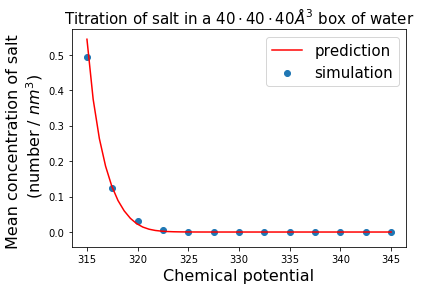

In [11]:
d = np.linspace(b40_deltachem[0], b40_deltachem[-1])
free_energy = np.hstack((0.0,np.cumsum(free)))

predicted_conc = np.zeros(len(d))
for i in range(len(d)):
    predicted_conc[i] = predict_concentration(-d[i], saltmax=20, mean_volume=ave_vol, f=-free_energy)
    
plt.scatter(b40_deltachem, b40_mean_conc, marker='o', label='simulation')
plt.plot(d, predicted_conc, color='red', label='prediction')
plt.xlabel('Chemical potential', fontsize=16)
plt.ylabel('Mean concentration of salt \n (number / $nm^3$)', fontsize=16)
plt.title('Titration of salt in a $40\cdot 40\cdot 40 \AA^3 $ box of water', fontsize=15)
plt.legend(fontsize=15)
plt.show()